In [1]:
from numpy.random import seed
import tensorflow as tf
# tensorflow.random.set_seed(1)
#from tensorflow import random
#random.set_seed(1)
import math
from pandas_datareader import data as pdr
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
import yfinance as yf
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from keras.optimizers import SGD, RMSprop, Adadelta

BANCO MACRO DE ARGENTINA

In [24]:
Banco = 'BMA'

BMA = yf.download(Banco, start='2006-04-01', end='2023-04-01')
#BMA

[*********************100%%**********************]  1 of 1 completed


In [50]:
Banco = 'CIB'

BCol = yf.download(Banco, start='2006-04-01', end='2023-04-01')
#BCol

[*********************100%%**********************]  1 of 1 completed


In [ ]:
BMA['Adj Close'].isnull().sum()

0

In [ ]:
BMA['Adj Close'].info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 4278 entries, 2006-04-03 to 2023-03-30
Series name: Adj Close
Non-Null Count  Dtype  
--------------  -----  
4278 non-null   float64
dtypes: float64(1)
memory usage: 66.8 KB


In [ ]:
BMA.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

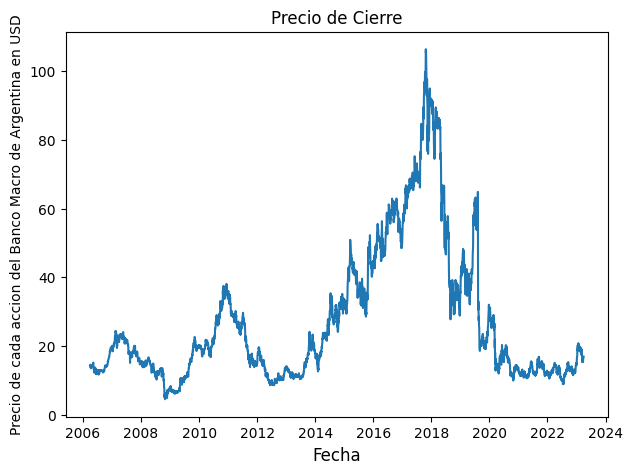

In [ ]:
# Banco Macro de Argentina

plt.figure(figsize=(7,5))
plt.title('Precio de Cierre')
plt.plot(BMA['Adj Close'])
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Precio de cada accion del Banco Macro de Argentina en USD', fontsize=10)
plt.show()

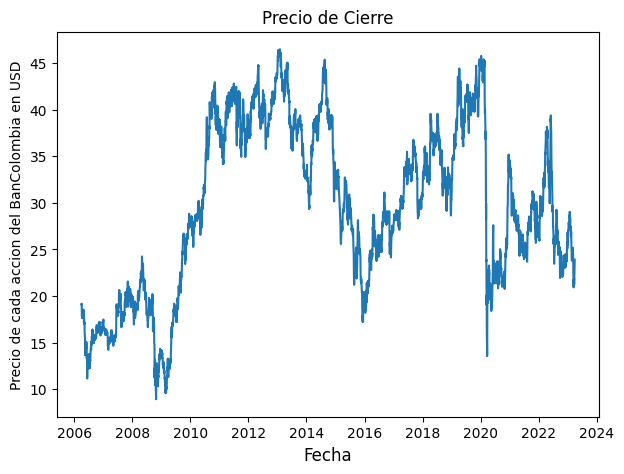

In [ ]:
# BanColombia

plt.figure(figsize=(7,5))
plt.title('Precio de Cierre')
plt.plot(BCol['Adj Close'])
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Precio de cada accion del BanColombia en USD', fontsize=10)
plt.show()

In [25]:
data = BMA.filter(['Adj Close'])
BMA_UniVar = data.values
BMA_UniVar

array([[14.02018166],
       [14.5760498 ],
       [14.45252705],
       ...,
       [16.94784927],
       [16.94784927],
       [16.24548912]])

In [51]:
data1 = BCol.filter(['Adj Close'])
BCol_UniVar = data1.values
BCol_UniVar

array([[18.4906559 ],
       [18.55263138],
       [17.98965645],
       ...,
       [22.56289482],
       [23.10900497],
       [23.53989792]])

In [26]:
#Escalamiento de la variable objetivo
Escalador = MinMaxScaler()
BMA_normalizado = Escalador.fit_transform(BMA_UniVar)
BMA_normalizado

array([[0.09335459],
       [0.09881322],
       [0.09760022],
       ...,
       [0.12210431],
       [0.12210431],
       [0.11520712]])

In [53]:
Escalador1 = MinMaxScaler()
BCol_normalizado = Escalador1.fit_transform(BCol_UniVar)
BCol_normalizado

array([[0.27155277],
       [0.27325955],
       [0.25775539],
       ...,
       [0.38370101],
       [0.39874072],
       [0.41060738]])

In [27]:
# Conjunto de Entrenamiento
training_dataset_len = math.ceil(len(BMA_normalizado)*.7)
training_dataset_len

2996

In [54]:
training_dataset_len1 = math.ceil(len(BCol_normalizado)*.7)
training_dataset_len1

2996

In [28]:
# Conjunto de Testeo
test_dataset_len = math.ceil(len(BMA_normalizado)*.3)
test_dataset_len

1284

In [55]:
test_dataset_len1 = math.ceil(len(BCol_normalizado)*.3)
test_dataset_len1

1284

In [29]:
Data_Estandardizada = BMA_normalizado

In [56]:
Data_Estandardizada1 = BCol_normalizado

In [30]:
Data_Entrenamiento = Data_Estandardizada[0:training_dataset_len, :]
x_train = []
y_train = []

for i in range(60, len(Data_Entrenamiento)):
  x_train.append(Data_Entrenamiento[i-60:i,0])
  y_train.append(Data_Entrenamiento[i,0])
  #if i <= 61:
    #print(x_train)
    #print(y_train)
    #print()

In [57]:
Data_Entrenamiento = Data_Estandardizada1[0:training_dataset_len1, :]
x_train1 = []
y_train1 = []

for i in range(60, len(Data_Entrenamiento)):
  x_train1.append(Data_Entrenamiento[i-60:i,0])
  y_train1.append(Data_Entrenamiento[i,0])
  #if i <= 61:
    #print(x_train)
    #print(y_train)
    #print()

In [31]:
#Obtencion en numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [58]:
x_train1, y_train1 = np.array(x_train1), np.array(y_train1)

In [ ]:
#Dimensiones del data set
x_train1.shape

(2935, 60)

In [32]:
# Tranformamos nuestro set de entrenamiento en 3 dimensiones para que la red neuronal pueda ser entrenada

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [60]:
x_train1 = np.reshape(x_train1, (x_train1.shape[0], x_train1.shape[1], 1))

In [61]:
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

In [62]:
#Implementacion de Red LSTM
model = Sequential()
model.add(LSTM(60, return_sequences=True, input_shape = (60,1)))
model.add(LSTM(60, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(50))
model.add(Dense(1))

In [ ]:
model = Sequential()
model.add(LSTM(60, return_sequences=True, input_shape = (60,1)))
model.add(LSTM(60, return_sequences=True, input_shape = (60,1)))
model.add(LSTM(60, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(50))
model.add(Dense(1))

In [ ]:
model = Sequential()
model.add(LSTM(60, return_sequences=True, input_shape = (60,1)))
model.add(LSTM(60, return_sequences=True, input_shape = (60,1)))
model.add(LSTM(60, return_sequences=True, input_shape = (60,1)))
model.add(LSTM(60, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(50))
model.add(Dense(1))

In [ ]:
!pip install scikeras

In [ ]:
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
from keras import optimizers

In [ ]:
seed = 7
tf.random.set_seed(seed)

In [ ]:
def create_model():
 model=Sequential()
 model.add(LSTM(60,return_sequences=True, input_shape=(60,1)))
 model.add(LSTM(60,return_sequences=False))
 model.add(Dropout(0.2))
 model.add(Dense(50))
 model.add(Dense(1))

 return model

In [ ]:
modelo = KerasRegressor(model=create_model, loss='mean_squared_error', batch_size=214, epochs=11, verbose=1)

In [ ]:
sgd = SGD(learning_rate=0.0001, momentum=0.9, nesterov=True)

In [ ]:
rmsprop = RMSprop(learning_rate= 0.001, rho=0.9, centered=True)

In [ ]:
adadelta = Adadelta()

In [ ]:
optimizador = [sgd, rmsprop, adadelta, 'Adam']

In [ ]:
param_grid = dict(optimizer=optimizador)

In [ ]:
grid = GridSearchCV(estimator=modelo, param_grid=param_grid, n_jobs=-1, cv=3)

In [ ]:
grid_result = grid.fit(x_train, y_train)

Epoch 1/11
14/14 [==============================] - 5s 191ms/step - loss: 0.0308
Epoch 2/11
14/14 [==============================] - 2s 121ms/step - loss: 0.0055
Epoch 3/11
14/14 [==============================] - 2s 123ms/step - loss: 0.0016
Epoch 4/11
14/14 [==============================] - 2s 122ms/step - loss: 0.0011
Epoch 5/11
14/14 [==============================] - 2s 123ms/step - loss: 0.0010
Epoch 6/11
14/14 [==============================] - 2s 128ms/step - loss: 9.8208e-04
Epoch 7/11
14/14 [==============================] - 2s 152ms/step - loss: 9.4956e-04
Epoch 8/11
14/14 [==============================] - 2s 148ms/step - loss: 8.7712e-04
Epoch 9/11
14/14 [==============================] - 2s 123ms/step - loss: 8.5145e-04
Epoch 10/11
14/14 [==============================] - 2s 120ms/step - loss: 8.7143e-04
Epoch 11/11
14/14 [==============================] - 2s 120ms/step - loss: 8.4933e-04


In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.952214 using {'optimizer': 'Adam'}
-4.257726 (2.184071) with: {'optimizer': <keras.src.optimizers.sgd.SGD object at 0x79877bb2ba30>}
0.899896 (0.023731) with: {'optimizer': <keras.src.optimizers.rmsprop.RMSprop object at 0x79877bb2be50>}
-3.276907 (1.825495) with: {'optimizer': <keras.src.optimizers.adadelta.Adadelta object at 0x79877bb2bd00>}
0.952214 (0.029600) with: {'optimizer': 'Adam'}


In [ ]:
model.compile(optimizer=sgd, loss='mean_squared_error')

In [ ]:
model.compile(optimizer=rmsprop, loss='mean_squared_error')

In [ ]:
model.compile(optimizer=adadelta, loss='mean_squared_error')

In [63]:
#Compilacion del Modelo
model.compile(optimizer='adam', loss='mean_squared_error')

In [36]:
#Entrenamiento de la red. BMA
model.fit(x_train, y_train, batch_size=214, epochs=11)

Epoch 1/11
14/14 [==============================] - 7s 214ms/step - loss: 0.0207
Epoch 2/11
14/14 [==============================] - 3s 204ms/step - loss: 0.0034
Epoch 3/11
14/14 [==============================] - 5s 353ms/step - loss: 0.0018
Epoch 4/11
14/14 [==============================] - 3s 197ms/step - loss: 0.0013
Epoch 5/11
14/14 [==============================] - 3s 205ms/step - loss: 0.0011
Epoch 6/11
14/14 [==============================] - 3s 212ms/step - loss: 0.0010
Epoch 7/11
14/14 [==============================] - 4s 302ms/step - loss: 0.0010
Epoch 8/11
14/14 [==============================] - 4s 253ms/step - loss: 8.4309e-04
Epoch 9/11
14/14 [==============================] - 3s 209ms/step - loss: 8.5424e-04
Epoch 10/11
14/14 [==============================] - 3s 196ms/step - loss: 7.5113e-04
Epoch 11/11
14/14 [==============================] - 3s 250ms/step - loss: 8.1559e-04


In [64]:
#Entrenamiento de la red. BCol
model.fit(x_train1, y_train1, batch_size=214, epochs=11)

Epoch 1/11
14/14 [==============================] - 8s 211ms/step - loss: 0.0681
Epoch 2/11
14/14 [==============================] - 5s 353ms/step - loss: 0.0132
Epoch 3/11
14/14 [==============================] - 3s 212ms/step - loss: 0.0067
Epoch 4/11
14/14 [==============================] - 3s 219ms/step - loss: 0.0046
Epoch 5/11
14/14 [==============================] - 3s 214ms/step - loss: 0.0036
Epoch 6/11
14/14 [==============================] - 5s 365ms/step - loss: 0.0032
Epoch 7/11
14/14 [==============================] - 3s 212ms/step - loss: 0.0031
Epoch 8/11
14/14 [==============================] - 3s 210ms/step - loss: 0.0028
Epoch 9/11
14/14 [==============================] - 3s 212ms/step - loss: 0.0028
Epoch 10/11
14/14 [==============================] - 4s 321ms/step - loss: 0.0027
Epoch 11/11
14/14 [==============================] - 3s 215ms/step - loss: 0.0025


In [38]:
#Creamos el set de testeo. BMA
Data_Testeo = Data_Estandardizada[training_dataset_len-60: , :]


x_test = []
y_test = BMA_UniVar[training_dataset_len:, :]
for i in range(60, len(Data_Testeo)):
  x_test.append(Data_Testeo[i-60:i, 0])

In [65]:
#Creamos el set de testeo. BMA
Data_Testeo1 = Data_Estandardizada1[training_dataset_len1-60: , :]

x_test1 = []
y_test1 = BCol_UniVar[training_dataset_len1:, :]
for i in range(60, len(Data_Testeo1)):
  x_test1.append(Data_Testeo1[i-60:i, 0])

In [39]:
#Convertimos el set a un array de numpy
x_test = np.array(x_test)

In [66]:
x_test1 = np.array(x_test1)

In [17]:
x_test.shape

(1283, 60)

In [40]:
#Reconvertimos el set de testeo a un espacio de 3 dimensiones
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [67]:
x_test1 = np.reshape(x_test1, (x_test1.shape[0], x_test1.shape[1], 1))

In [41]:
#Generamos la prediccion. BMA
prediccion = model.predict(x_test)
prediccion = Escalador.inverse_transform(prediccion)

41/41 [==============================] - 2s 18ms/step


In [69]:
#Generamos la prediccion. BCol
prediccion2 = model.predict(x_test1)
prediccion2 = Escalador1.inverse_transform(prediccion2)

41/41 [==============================] - 1s 19ms/step


In [ ]:
##Evaluamos el modelo
## RMSE

rmse = np.sqrt(np.mean(prediccion- y_test)**2)
rmse

0.8127196721517752

In [ ]:
rmse = np.sqrt(np.mean(prediccion2- y_test1)**2)
rmse

0.6097961724594247

In [ ]:
## MSE

mse = np.mean(prediccion- y_test)**2
mse

1.0650255537565074

In [ ]:
mse = np.mean(prediccion2- y_test1)**2
mse

0.09850006020912576

In [ ]:
## MAE

mae = np.mean(prediccion-y_test)
mae

1.2341072739610799

In [ ]:
mae = np.mean(prediccion2- y_test1)
mae

0.0894643117558278

<ipython-input-74-4fba4a39d7d6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predicciones'] = prediccion


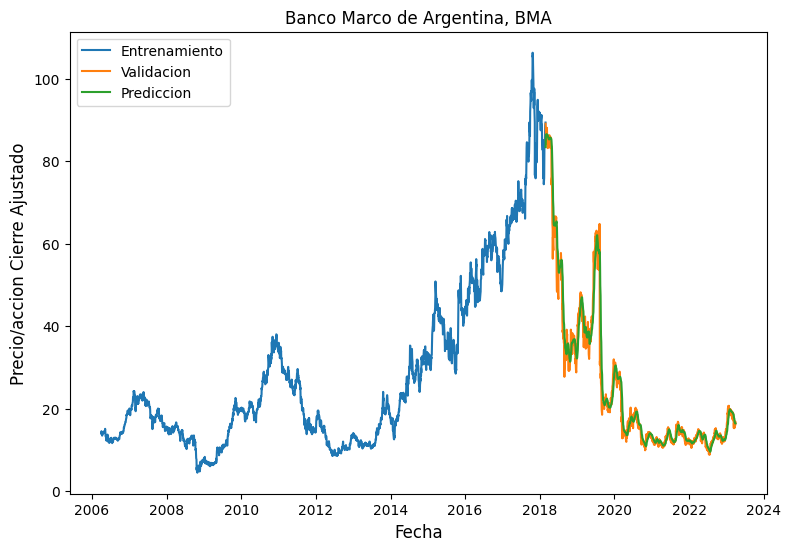

In [74]:
# Visualizacion
train = data[:training_dataset_len]
valid = data[training_dataset_len:]
valid['Predicciones'] = prediccion

plt.figure(figsize=(9,6))
plt.title('Banco Marco de Argentina, BMA')
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Precio/accion Cierre Ajustado', fontsize=12)
plt.plot(train['Adj Close'])
plt.plot(valid[['Adj Close', 'Predicciones']])
plt.legend(['Entrenamiento', 'Validacion', 'Prediccion'], loc='upper left')
plt.show()

<ipython-input-75-abb9338a3222>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid1['Predicciones'] = prediccion2


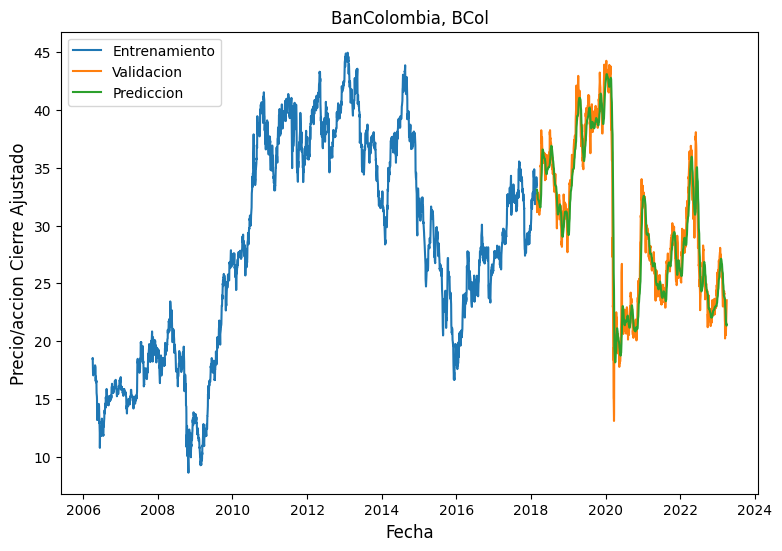

In [75]:
# Visualizacion
train1 = data1[:training_dataset_len1]
valid1 = data1[training_dataset_len1:]
valid1['Predicciones'] = prediccion2

plt.figure(figsize=(9,6))
plt.title('BanColombia, BCol')
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Precio/accion Cierre Ajustado', fontsize=12)
plt.plot(train1['Adj Close'])
plt.plot(valid1[['Adj Close', 'Predicciones']])
plt.legend(['Entrenamiento', 'Validacion', 'Prediccion'], loc='upper left')
plt.show()

In [ ]:
train = data[:training_dataset_len]
valid = data1[training_dataset_len1:]
valid['Predicciones'] = prediccion2

plt.figure(figsize=(12,7))
plt.title('Modelo BCol')
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Precio/accion Cierre Ajustado', fontsize=12)
plt.plot(train['Adj Close'])
plt.plot(valid[['Adj Close', 'Predicciones']])
plt.legend(['Entrenamiento', 'Validacion', 'Prediccion'], loc='upper left')
plt.show()

<ipython-input-67-fecf4b5baaea>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predicciones'] = prediccion2


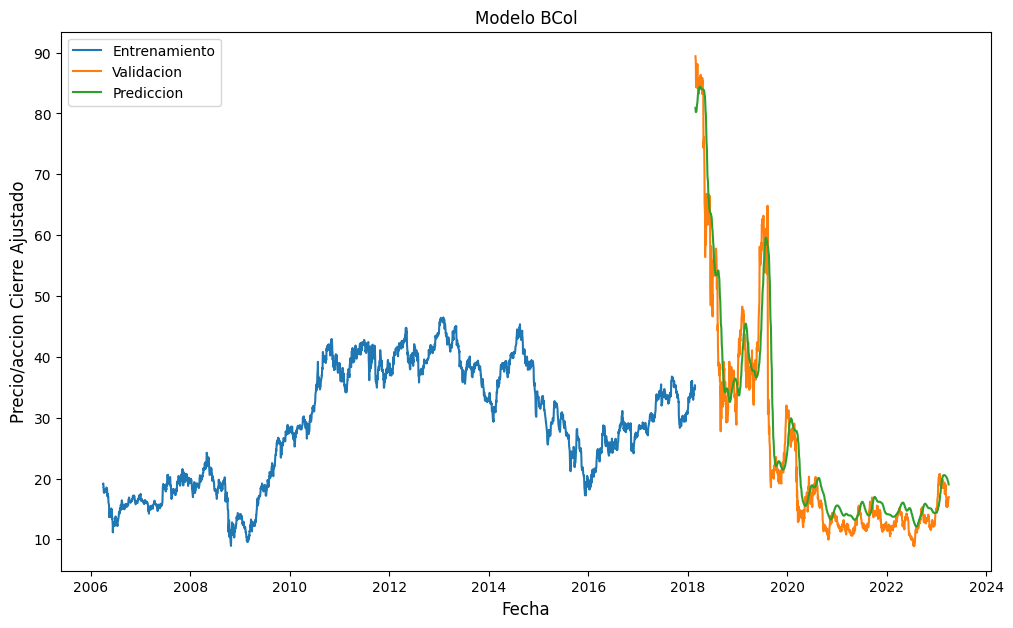

In [ ]:
train = data1[:training_dataset_len1]
valid = data[training_dataset_len:]
valid['Predicciones'] = prediccion2

plt.figure(figsize=(12,7))
plt.title('Modelo BCol')
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Precio/accion Cierre Ajustado', fontsize=12)
plt.plot(train['Adj Close'])
plt.plot(valid[['Adj Close', 'Predicciones']])
plt.legend(['Entrenamiento', 'Validacion', 'Prediccion'], loc='upper left')
plt.show()

In [43]:
#Observamos el precio real y el pronosticado
valid

,Adj Close,Predicciones
Date,,
2018-02-27,89.137642,83.461098
2018-02-28,88.800041,84.411255
2018-03-01,87.622437,85.268715
2018-03-02,84.953178,85.962204
2018-03-05,84.278000,86.380188
...,...,...
2023-03-27,16.464405,16.589703
2023-03-28,16.601231,16.485302
2023-03-29,16.947849,16.432734


In [71]:
valid1.tail(14)

,Adj Close,Predicciones
Date,,
2023-03-14,21.608381,23.611542
2023-03-15,20.235699,23.459764
2023-03-16,21.053854,23.220335
2023-03-17,20.499327,22.959108
2023-03-20,20.735682,22.672670
2023-03-21,21.226576,22.390039
2023-03-22,21.062944,22.142031
2023-03-23,20.535690,21.924032
2023-03-24,20.853861,21.716558


In [21]:
#Prediccion del precio de las acciones
ultimos_60_dias = data[-60:].values

#Estandardizacion
ultimos_60_dias_Estand = Escalador.transform(ultimos_60_dias)

X_test = []
X_test.append(ultimos_60_dias_Estand)

#Convertimos a numpy array
X_test = np.array(X_test)

#Transformacion Dimensional
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

#Prediccion
Precio_Predecido = model.predict(X_test)

#Revertir estandardizacion
Precio_Predecido = Escalador.inverse_transform(Precio_Predecido)
print(Precio_Predecido)


1/1 [==============================] - 0s 26ms/step
[[15.998056]]


In [22]:
Banco = 'BMA'

BMacro = yf.download(Banco, start='2023-03-31', end='2023-04-04')
BMacro

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-03-31,18.67,18.68,17.41,17.809999,16.245491,182500
2023-04-03,17.82,18.52,17.60,18.430000,16.811026,148500
